In [1]:
# Compatibilidad con Python 3
from __future__ import print_function, division

import sys
import pylab as pl
import pandas as pd
import numpy as np
import os
import json
import requests
import urllib2
import urllib
import ast
from cStringIO import StringIO

import geopandas as gpd
from geopandas import GeoDataFrame
import pysal as ps
from fiona.crs import from_epsg
import matplotlib.colors as mcolors
import operator
from matplotlib.colors import ListedColormap    

import shapely as sy
from shapely.geometry import Point
from shapely.geometry import Polygon
from shapely.ops import cascaded_union
from time import sleep

%pylab inline

Populating the interactive namespace from numpy and matplotlib


C:\Program Files\Anaconda2\lib\site-packages\IPython\core\magics\pylab.py:161: UserWarning: pylab import has clobbered these variables: ['Polygon']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [6]:
# load NYC zips shapefiles into geodataframe
# https://geo.nyu.edu/catalog/nyu_2451_34509

filePath = "data/nyu_2451_34509.shp"
geoZips = GeoDataFrame.from_file(filePath)

filePath = "data/neighbourhoods.geojson"
geoNeigh = GeoDataFrame.from_file(filePath)

# rename zip column
geoZips.rename(columns={'zcta': 'zip'}, inplace=True)

# Change the CRS to lat long
crs = {'init': 'epsg:4326'}
# geoZips = GeoDataFrame(geoZips, crs=crs)
geoNeigh = GeoDataFrame(geoNeigh, crs=crs)

geoZips = geoZips.to_crs(epsg=4326)
geoNeigh = geoNeigh.to_crs(epsg=4326)

# Quick exploration of the data
geoZips.head()

,bcode,geometry,note,zip
0,36061,POLYGON ((-74.00368399999998 40.74835500003317...,None,10001
1,36061,POLYGON ((-73.99694699999998 40.71207200003317...,None,10002
2,36061,POLYGON ((-73.99206099999998 40.72564200003317...,None,10003
3,36061,(POLYGON ((-74.02665800000001 40.6857150000331...,None,10004
4,36061,"POLYGON ((-74.009029 40.70531000003317, -74.00...",None,10005


Text(0.5,1,u'NYC: ZIPS\n')

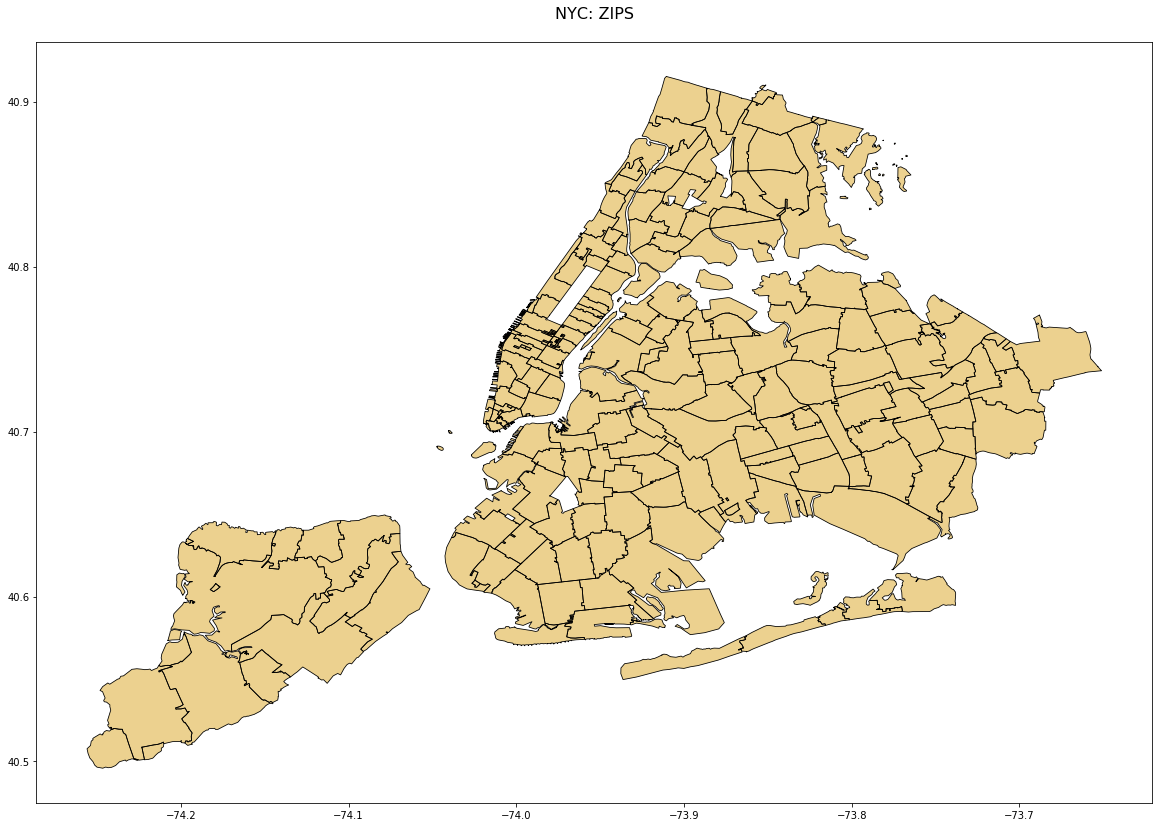

In [39]:
# visualize
f, ax = pl.subplots(figsize=(20,14))
geoZips.plot(linewidth = 0.8, color = 'goldenrod', alpha = 0.5, ax = ax)
#geoNeigh.plot(linewidth = 0.4, color = 'goldenrod', alpha = 0.5, ax = ax)

pl.title("NYC: ZIPS\n", size=16)

In [46]:
# Get the listings from insideairbnb
# http://data.insideairbnb.com/united-states/ny/new-york-city/2017-10-02/visualisations/listings.csv

filePath = "data/listings.csv"
dfListings = pd.read_csv(filePath)
dfListings.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,18461891,"Bright, comfortable 1B studio near everything!",916092,Connie Mae,Queens,Ditmars Steinway,40.774142,-73.916246,Entire home/apt,110,6,0,NaN,NaN,1,0
1,20702398,Quiet house on City Island,1457680,James,Bronx,City Island,40.849191,-73.786509,Private room,50,1,2,2017-10-01,2.00,1,169
2,6627449,Large 1 BDRM in Great location,13886510,Arlene,Bronx,City Island,40.849775,-73.786609,Entire home/apt,125,3,21,2017-09-26,0.77,1,363
3,19949243,Stay aboard a sailboat,1149260,MoMo,Bronx,City Island,40.848838,-73.782276,Entire home/apt,100,3,0,NaN,NaN,1,90
4,1886820,Quaint City Island Community.,9815788,Steve,Bronx,City Island,40.841144,-73.783052,Entire home/apt,300,7,0,NaN,NaN,1,365


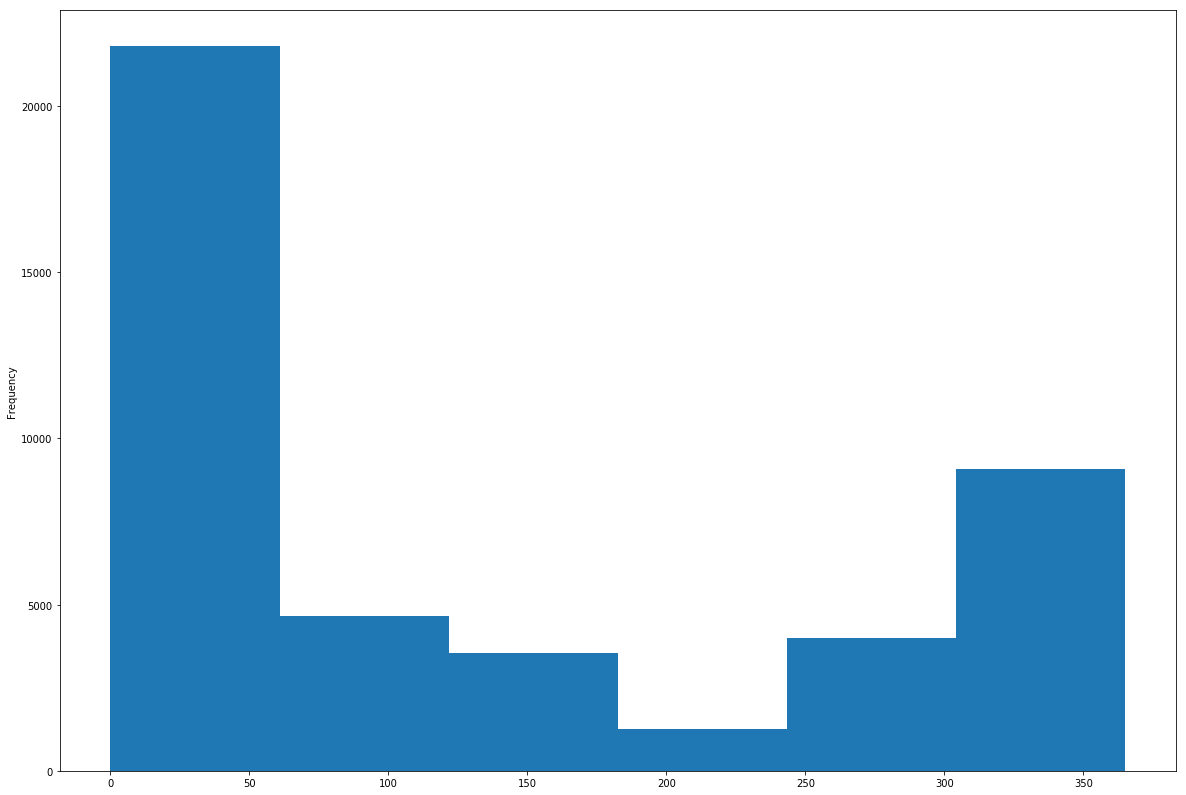

In [163]:
# Plot frequencies for bins on availability
f, ax = pl.subplots(figsize=(20,14))
dfListings['availability_365'].plot.hist (bins=6, ax=ax)

In [47]:
# Convert the listings dataframe into a geodatafram

# Build a geometry colum by creating point objects out of the lat and long of listings
geometry = [Point(xy) for xy in zip(dfListings.longitude, dfListings.latitude)]

# Drop the original lat and long columns and cast to geodataframe
# Initialized with the crs epsg 4326
dfListings = dfListings.drop(['longitude', 'latitude'], axis=1)
crs = {'init': 'epsg:4326'}
gdfListings = GeoDataFrame(dfListings, crs=crs, geometry=geometry)

In [67]:
# The listing has an availability field
# Lets get only those listings available for more than 300 days

gdfListingsAllYear = gdfListings[gdfListings.availability_365 > 300]
print(len(gdfListingsAllYear.index))

9453


Text(0.5,1,u'NYC: ZIPS\n')

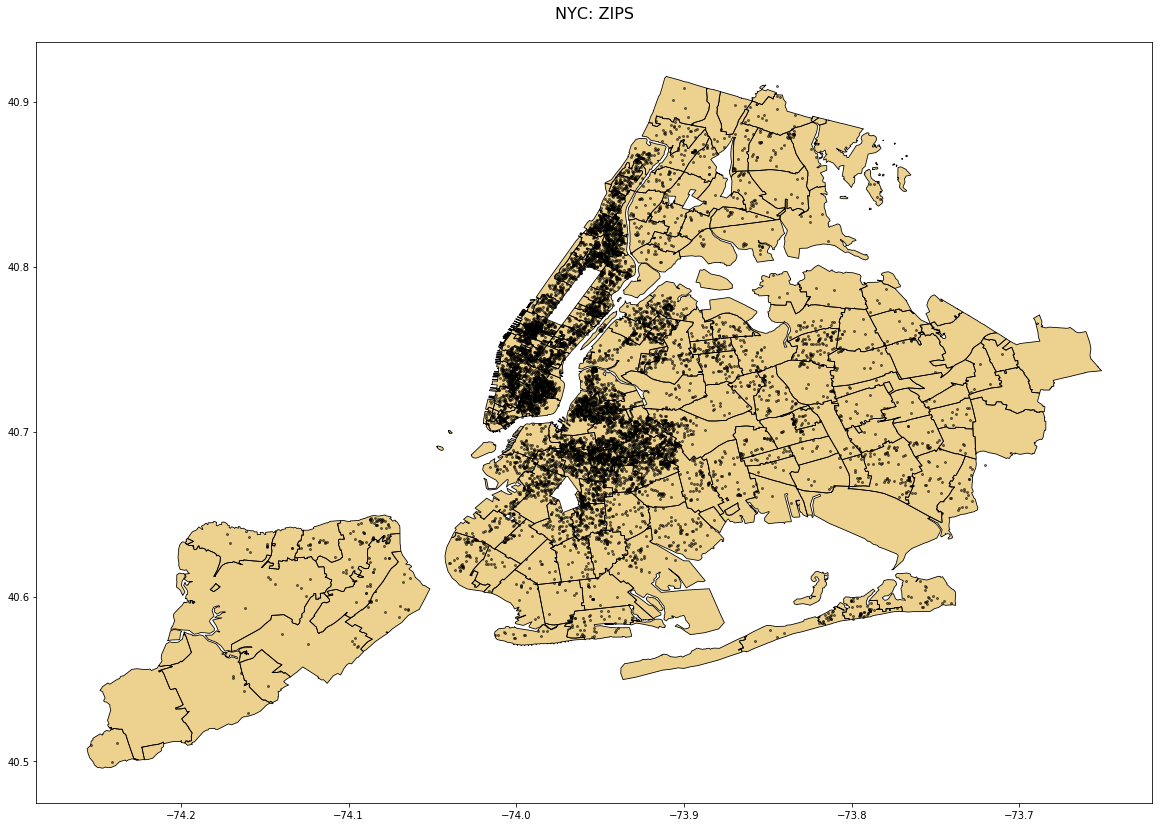

In [50]:
# visualize
f, ax = pl.subplots(figsize=(20,14))
geoZips.plot(linewidth = 0.8, color = 'goldenrod', alpha = 0.5, ax = ax)
gdfListingsAllYear.plot(linewidth = 0.4, color = 'black', alpha = 0.5, ax = ax)

pl.title("NYC: Zip codes and AirBnB listings (available more than 300 days a year)\n", size=16)

In [116]:
gdfListingsAllYear.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,geometry,zip
2,6627449,Large 1 BDRM in Great location,13886510,Arlene,Bronx,City Island,Entire home/apt,125,3,21,2017-09-26,0.77,1,363,POINT (-73.78660938743727 40.84977456920603),10464
4,1886820,Quaint City Island Community.,9815788,Steve,Bronx,City Island,Entire home/apt,300,7,0,NaN,NaN,1,365,POINT (-73.78305228672215 40.84114416028828),10464
5,5557381,Quaint City Island Home,28811542,Phoebe,Bronx,City Island,Private room,69,3,94,2017-07-31,3.27,1,325,POINT (-73.78932759494228 40.85002381416047),10464
8,21057372,Relax and unwind on the water.,151702414,David,Bronx,City Island,Entire home/apt,100,1,0,NaN,NaN,1,364,POINT (-73.78519697954233 40.84212398380699),10464
13,11675715,Cozy 1 BR Basement Apartment,56714504,Josue,Bronx,City Island,Entire home/apt,85,1,110,2017-09-11,5.88,1,332,POINT (-73.78413886754987 40.85139147552059),10464


In [129]:
# Iterate through points and see which zip they bellong to
for indexListing, rowListing in gdfListingsAllYear.iterrows():
    listingPoint = Point(rowListing.geometry.centroid)
    for indexZip, rowZip in geoZips.iterrows():
        if listingPoint.within(rowZip['geometry']):
            gdfListingsAllYear.loc[[indexListing,14],'zip'] = geoZips.zip[indexZip]

In [130]:
gdfListingsAllYear.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,geometry,zip
2,6627449,Large 1 BDRM in Great location,13886510,Arlene,Bronx,City Island,Entire home/apt,125,3,21,2017-09-26,0.77,1,363,POINT (-73.78660938743727 40.84977456920603),10464
4,1886820,Quaint City Island Community.,9815788,Steve,Bronx,City Island,Entire home/apt,300,7,0,NaN,NaN,1,365,POINT (-73.78305228672215 40.84114416028828),10464
5,5557381,Quaint City Island Home,28811542,Phoebe,Bronx,City Island,Private room,69,3,94,2017-07-31,3.27,1,325,POINT (-73.78932759494228 40.85002381416047),10464
8,21057372,Relax and unwind on the water.,151702414,David,Bronx,City Island,Entire home/apt,100,1,0,NaN,NaN,1,364,POINT (-73.78519697954233 40.84212398380699),10464
13,11675715,Cozy 1 BR Basement Apartment,56714504,Josue,Bronx,City Island,Entire home/apt,85,1,110,2017-09-11,5.88,1,332,POINT (-73.78413886754987 40.85139147552059),10464


In [132]:
gdfListingsAllYear.to_file("data/gdfListingsAllYear.geojson",
                           driver='GeoJSON')

In [2]:
filePath = "data/gdfListingsAllYear.geojson"
gdf = GeoDataFrame.from_file(filePath)
gdf['listing']=1

In [3]:
gdf = gdf.groupby(['zip'],as_index=False).sum()


In [7]:
gdf=gdf[['zip','listing']]

In [8]:
geoZips = pd.merge(geoZips, gdf, on=['zip'])
geoZips = GeoDataFrame(geoZips, geometry='geometry')


In [10]:
geoZips.head()
geoZips.to_file("data/gdfListingsAllYearByZip.geojson",
                           driver='GeoJSON')

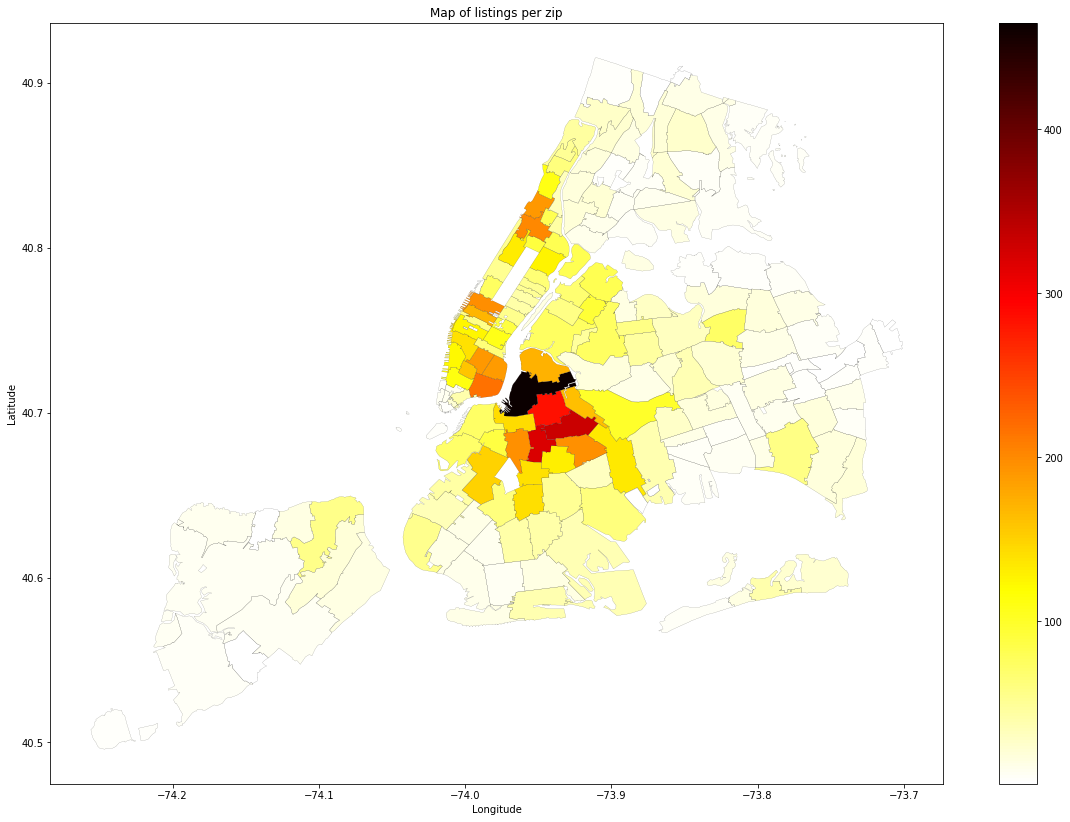

In [171]:
# Plot
fig, ax = pl.subplots(figsize=(20,14))

geoZips.plot(column='listing', cmap='hot_r', alpha=1,
                        linewidth=0.1, ax=ax)

ax.set_title('Map of listings per zip')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

normalize = mcolors.Normalize(vmin=geoZips.listing.min(),
                              vmax=geoZips.listing.max())
colormap = cm.hot_r
scalarmappaple = cm.ScalarMappable(norm=normalize, cmap=colormap)
scalarmappaple.set_array(geoZips.listing)
pl.colorbar(scalarmappaple, ax=ax)